In [12]:
import warnings
warnings.filterwarnings("ignore")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import fsspec
import json
from tqdm import tqdm
from glob import glob
from ncar_jobqueue import NCARCluster
import dask
import os
import xcesm
import intake
import seaborn as sns
from xCMIP import cmip_mdl
import pandas as pd
import proplot as pplt
import hvplot.pandas
import xcesm.plots.colormap as clp
pplt.rc.cycle = 'FlatUI'
pplt.rc.grid = 'off'

In [13]:
amv = xr.open_dataarray('0temp_data/gs.CMIP6.historical.AMV.JJASO.pub.nc').convert_calendar('gregorian')
vws = xr.open_dataarray('0temp_data/gs.CMIP6.historical.VWS.JJASO.pub1.nc').convert_calendar('gregorian')
spr = xr.open_dataarray('0temp_data/gs.CMIP6.historical.Sahel-pr.JJASO.pub.nc').convert_calendar('gregorian') * 86400
amoc = xr.open_dataarray('0temp_data/gs.CMIP6.historical.AMOC.EM.ann.1900-2015.nc').convert_calendar('gregorian').sel(time=slice('1950','2014'))

dsst = xr.open_dataarray('0temp_data/gs.CMIP6.historical.dSST.JJASO-annual.pub2.nc').convert_calendar('gregorian')

In [14]:
ds = xr.merge([amv.rename('amv'), vws.rename('vws'), spr.rename('spr'), dsst.rename('dsst')], join='inner')

In [15]:
def is_amj(month):
    return (month >= 6) & (month <= 10)

def remove_monthly_climatology(ds):
    grp = ds.groupby('time.month')
    return grp - grp.mean('time')

def cal_amv(ts):
    return ts.sel(lat=slice(0, 60), lon=slice(290, 360)).utils.globalmean()

def rotate_lon(ds):
    ds = ds.assign_coords(lon2=(((ds.lon + 180) % 360) - 180)).sortby('lon2')
    ds = ds.swap_dims({'lon':'lon2'})
    return ds

def rotate_lon2(ds):
    ds['lon2'] = ds.lon2 % 360
    ds = ds.sortby('lon2')
    return ds

In [16]:
moc_ob = xr.open_dataset('0temp_data/RAPID/moc_transports.nc')

sst = xr.open_dataset('0temp_data/ERSST/sst.mnmean.nc').sortby('lat')
sst = sst.sst.sel(time=slice('1945', '2020'))
sst = sst.sel(time=is_amj(sst['time.month']))
sst = remove_monthly_climatology(sst)
sst = sst.resample(time='1Y').mean()
# sst = rotate_lon(sst)
amv_ersst = cal_amv(sst)
# amv_ersst_raw = amv_ersst

sst = xr.open_dataset('0temp_data/ERSST/sst.mnmean.nc').sst.sortby('lat')
# sst = sst.sst.sel(time=slice('1945', '2020'))
sst = sst.sel(time=is_amj(sst['time.month'])).load()
sst = remove_monthly_climatology(sst)
sst = sst.resample(time='1Y').mean()
sst = rotate_lon(sst)

mask = xcesm.core.utils.mask_g16
mask = mask.utils.regrid()
mask = mask.rename({'lon':'lon2'})
mask = mask.interp_like(sst)

sst = sst.where(mask==6)
ob_dsst = sst.sel(lat=slice(0, 35)).mean(['lat','lon2']) - sst.sel(lat=slice(-35, 0)).mean(['lat','lon2'])


uwind = xr.open_dataarray('0temp_data/NCEP/uwnd.mon.mean.nc').sortby('lat')
uwind = uwind.sel(time=slice('1945', '2020'))
uwind = uwind.sel(time=is_amj(uwind['time.month']))
uwind = remove_monthly_climatology(uwind)
uwind = uwind.resample(time='1Y').mean()
uwind = uwind.sel(lat=slice(10, 20), lon=slice(280, 340))
vws_ncep = uwind.sel(level=200) - uwind.sel(level=850)
vws_ncep = vws_ncep.mean(['lat', 'lon'])
vs_ncep = vws_ncep



precip = xr.open_dataarray('/glade/work/che43/projects/AMV-impacts/0temp_data/GPCC/precip.mon.total.1x1.v7.nc') / 30 # to mm/day
precip = precip.sortby('lat')

precip = precip.sel(time=slice('1950', '2015'))
precip = precip.sel(time=is_amj(precip['time.month']))
precip = precip.resample(time='1Y').mean()
# precip = precip.assign_coords(lon2=(((precip.lon + 180) % 360) - 180)).sortby('lon2')
# precip = precip.swap_dims({'lon':'lon2'})
precip = rotate_lon(precip)

llt = slice(10, 20)
lln = slice(-20, 40)

obs_spr = precip.sel(lat=llt, lon2=lln).mean(['lat','lon2'])
obs_spr_raw = obs_spr

obs = xr.merge([amv_ersst.rename('amv'), 
                vs_ncep.rename('vws'), 
               obs_spr.rename('spr'), 
             ob_dsst.rename('dsst'),])
obs = obs.sel(time=slice('1950', '2014'))
obs['spr']  = obs.spr.interpolate_na(fill_value="extrapolate", dim='time')

In [17]:
obs_corr = xr.open_dataset('0temp_data/obs.corr.amv.vws.spr.multiple.dataset.nc')
obs_corr.attrs['units'] = ''
obs_corr.amv_vws.attrs['units'] = ''
obs_corr.amv_spr.attrs['units'] = ''


amv_vws = xr.concat([obs_corr.amv_vws, obs_corr.amv_vws, obs_corr.amv_vws], dim='i').sortby('i').dropna('i')
amv_spr = xr.concat([obs_corr.amv_spr, obs_corr.amv_spr], dim='i').sortby('i').dropna('i')


In [18]:
hy = xr.open_dataarray('0temp_data/hurdat.nc')
hy['time'] = xr.cftime_range(start='1900', periods=len(hy.time), freq='A')
hy = hy.convert_calendar('gregorian')


hyd = hy.sel(time=slice('1945', '2015')).stat.detrend(hy.sel(time=slice('1945', '2015')).time.dt.year)
hydl = hyd.stat.filter_butter(dt=1, band=10).sel(time=slice('1950', '2014')).stat.normalize()


In [19]:

ds_amv_vws = xr.open_dataset('0temp_data/fig3/role.of.single-forcing.AMV-VWS.nc')
ds_amv_spr = xr.open_dataset('0temp_data/fig3/role.of.single-forcing.AMV-SPR.nc')
ds_role = xr.open_dataset('0temp_data/fig3/role.of.single-forcing.dom_ana.coe.pub.nc')

In [20]:
def detrend_lowpass_filter(ds):
    return ds.stat.detrend(ds.time.dt.year).stat.filter_butter(dt=1, band=10).stat.normalize()

def detrend(ds):
    return ds.stat.detrend(ds.time.dt.year).stat.normalize()

def detrend_lowpass_filter2(ds):
    return ds.stat.detrend(ds.time.dt.year).stat.filter_butter(dt=1, band=10)

def detrend2(ds):
    return ds.stat.detrend(ds.time.dt.year)

In [21]:
dsm = ds.mean('mb')
dsml = dsm.map(detrend2)
dsmld = dsm.map(detrend_lowpass_filter2)
dsmldvar = dsmld.var('time')

dsld = ds.map(detrend_lowpass_filter2)
dsldvar = dsld.var('time')

obl = obs.map(detrend2)
obld = obs.map(detrend_lowpass_filter2)
obldvar = obld.var('time')

In [22]:
dsm = ds.mean('mb')
dsml = dsm.map(detrend)
dsmld = dsm.map(detrend_lowpass_filter)


dsld = ds.map(detrend_lowpass_filter)
c_amv_spr = dsld.amv.stat.corr_with(dsld.spr)
c_amv_vws = dsld.amv.stat.corr_with(dsld.vws)

c_amv_spr.attrs['units'] = ''
c_amv_vws.attrs['units'] = ''

em_amv_spr = dsmld.amv.stat.corr_with(dsmld.spr)
em_amv_vws = dsmld.amv.stat.corr_with(dsmld.vws)


dsld_p = (ds - ds.mean('mb')).map(detrend_lowpass_filter)
i_amv_spr = dsld_p.amv.stat.corr_with(dsld_p.spr)
i_amv_vws = dsld_p.amv.stat.corr_with(dsld_p.vws)

amocl = amoc.stat.detrend(amoc.time.dt.year)

In [23]:
obl = obs.map(detrend)
obld = obs.map(detrend_lowpass_filter)

(-1.0, 0.5)

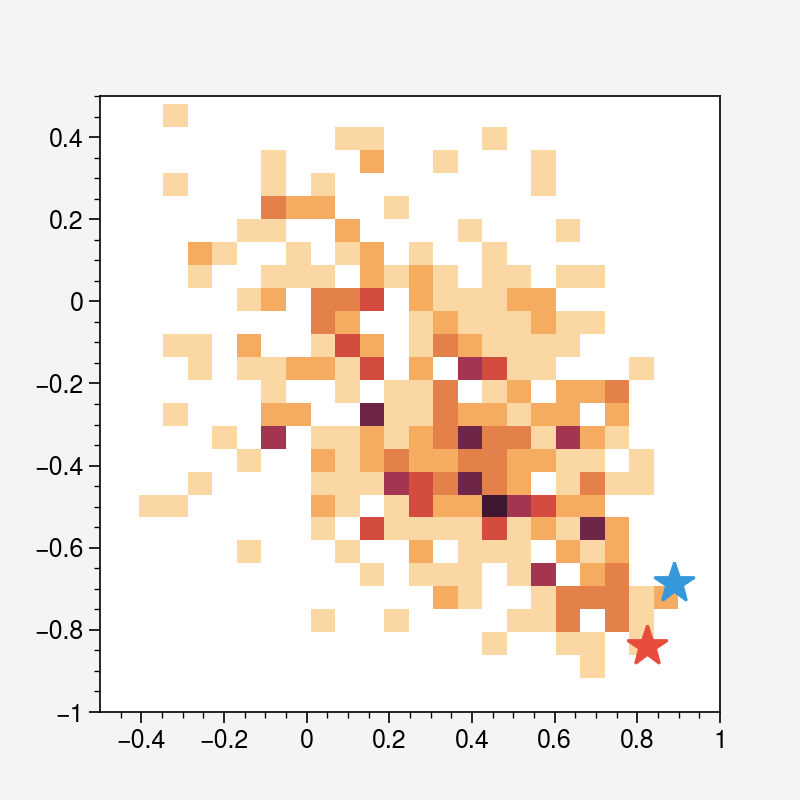

In [24]:
corr1 = xr.merge([c_amv_spr.rename('amv_spr'),
                 c_amv_vws.rename('amv_vws')]).dropna('mb')

hhp1 = plt.hist2d(corr1.amv_spr, corr1.amv_vws, bins=25)
plt.plot(em_amv_spr, em_amv_vws, '*', ms=15)
plt.plot(obs_corr.amv_spr.mean(), obs_corr.amv_vws.mean(), '*', ms=15)

plt.xlim([-0.5, 1])
plt.ylim([-1, 0.5])

(-1.0, 0.5)

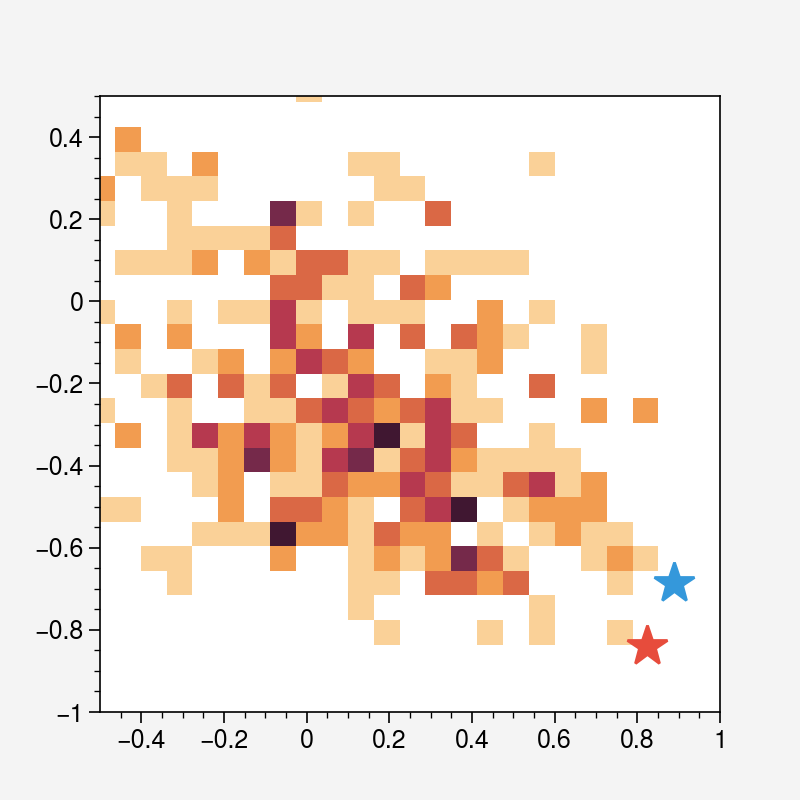

In [25]:
corr2 = xr.merge([i_amv_spr.rename('amv_spr'),
                 i_amv_vws.rename('amv_vws')]).dropna('mb')

hhp2 = plt.hist2d(corr2.amv_spr, corr2.amv_vws, bins=25)
plt.plot(em_amv_spr, em_amv_vws, '*', ms=15)
plt.plot(obs_corr.amv_spr.mean(), obs_corr.amv_vws.mean(), '*', ms=15)

plt.xlim([-0.5, 1])
plt.ylim([-1, 0.5])

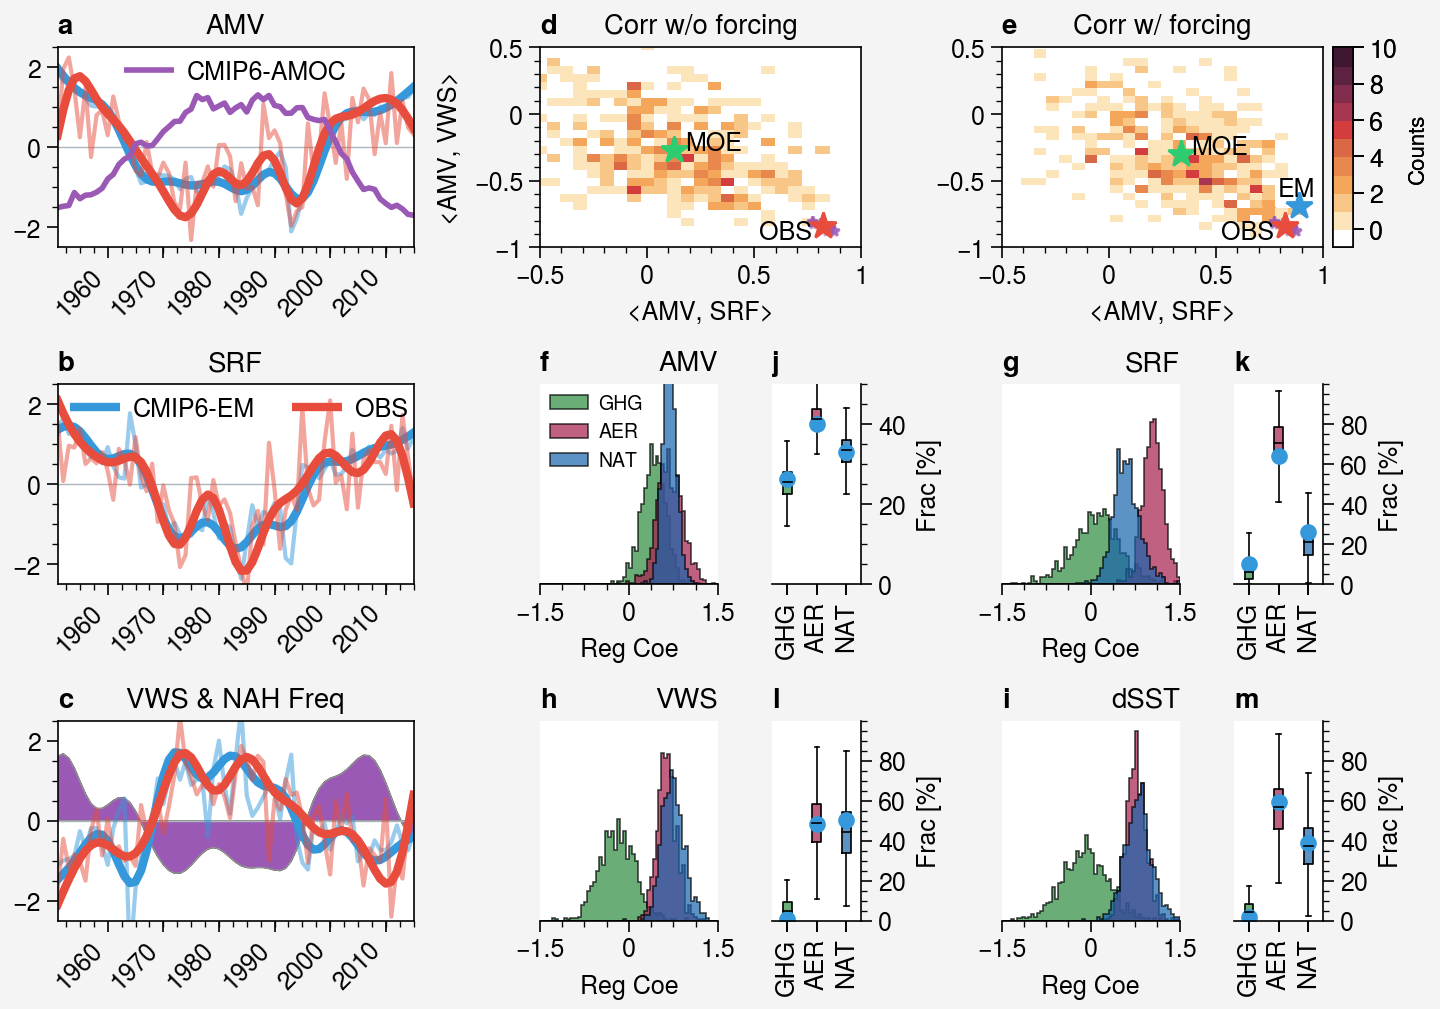

In [26]:
layout = [[1, 1, 2, 2, 3, 3],
          [4, 4, 5, 5, 6, 6],
          [7, 8, 9, 10, 11, 12],
]

layout = [
    [1, 1, 1,1, 4, 4, 4, 5, 5, 5],
    [2, 2, 2,2, 6, 6, 10,  7, 7,11],     
    [3, 3, 3,3, 8, 8, 12,  9, 9,13],      
         ]

fig, axs = pplt.subplots(layout, sharey=False, sharex=False, 
                          refnum=2, refwidth=1, refheight=1, journal='nat2', )

dsmld.amv.plot(ax=axs[0], lw=3)


dsml.amv.plot(ax=axs[0], c='C0', alpha=0.5)
obld.amv.plot(ax=axs[0], lw=3)
obl.amv.plot(ax=axs[0], c='C1', alpha=0.5)
amocl.stat.normalize().plot(ax=axs[0], lw=2, label='CMIP6-AMOC', c='C5')
axs[0].hlines(0, dsmld.amv.time.min(), dsmld.amv.time.max(), c='gray5', lw=0.5)


dsmld.spr.plot(ax=axs[1], lw=3, label='CMIP6-EM')
dsml.spr.plot(ax=axs[1], c='C0', alpha=0.5)
detrend_lowpass_filter(obs.spr.dropna('time')).plot(ax=axs[1], lw=3, label='OBS')
obl.spr.plot(ax=axs[1], c='C1', alpha=0.5)
axs[1].hlines(0, dsmld.spr.time.min(), dsmld.spr.time.max(), c='gray5', lw=0.5)

dsmld.vws.plot(ax=axs[2], lw=3)
dsml.vws.plot(ax=axs[2], c='C0', alpha=0.5)
obld.vws.plot(ax=axs[2], lw=3)
obl.vws.plot(ax=axs[2], c='C1', alpha=0.5)
axs[2].hlines(0, dsmld.vws.time.min(), dsmld.vws.time.max(), c='gray5', lw=0.5)


# axs[2].area(hydl, negpos=True, negcolor='#4891bc', poscolor='#e23e28', lw=0.5, edgecolor='gray')
# axs[2].area(hydl, negpos=True, negcolor='lime3', poscolor='orange3', lw=0.5, edgecolor='gray')
axs[2].area(hydl, negpos=True, negcolor='#79AB7C', poscolor='#B46681', lw=0.5, edgecolor='k')
axs[2].area(hydl, negpos=True, negcolor='C5', poscolor='C5', lw=0.5, edgecolor='gray')





lev = np.arange(-1, 10.1, 1)

m = axs[3].pcolor(hhp2[1], hhp2[2], hhp2[0].T, levels = lev, extend='neither')
fig.colorbar(m, loc='r', width=0.1, ticks=lev[1::2], row=[1,1], label='Counts', labelsize=8, pad=0.1)

# axs[3].plot(em_amv_spr, em_amv_vws, '*', ms=10, label='EM')
axs[3].plot(amv_spr, amv_vws, '*', ms=4, label='OBS', c='C5', alpha=0.5)
axs[3].plot(obs_corr.amv_spr.mean(), obs_corr.amv_vws.mean(), '*', ms=10, label='OBS', c='C1')
axs[3].plot(corr2.amv_spr.mean(), corr2.amv_vws.mean(), '*', ms=10, c='C4', label='MOE')

axs[3].text(obs_corr.amv_spr.mean()-0.3, obs_corr.amv_vws.mean()-0.1,'OBS')
axs[3].text(corr2.amv_spr.mean()+0.05, corr2.amv_vws.mean(),'MOE')






m = axs[4].pcolor(hhp1[1], hhp1[2], hhp1[0].T, levels = lev, extend='neither')
# axs[3].colorbar(m, loc='r', width=0.1, ticks=lev[::2], label='Counts')
axs[4].plot(em_amv_spr, em_amv_vws, '*', ms=10, label='EM')
axs[4].plot(amv_spr, amv_vws, '*', ms=4, label='OBS', c='C5', alpha=0.5)
axs[4].plot(obs_corr.amv_spr.mean(), obs_corr.amv_vws.mean(), '*', ms=10, label='mean-OBS')
axs[4].plot(corr1.amv_spr.mean(), corr1.amv_vws.mean(), '*', ms=10, c='C4', label='MOE')

axs[4].text(obs_corr.amv_spr.mean()-0.3, obs_corr.amv_vws.mean()-0.1,'OBS')
axs[4].text(em_amv_spr-0.1, em_amv_vws+0.07,'EM')
axs[4].text(corr1.amv_spr.mean()+0.05, corr1.amv_vws.mean(),'MOE')



axs.format(ylabel='', xlabel='',abc=True, xrotation=0)

axs[0].legend(frame=False, ncols=2)
axs[1].legend(frame=False, ncols=2)

axs[0].format(title='AMV')
axs[1].format(title='SRF')
axs[2].format(title='VWS & NAH Freq')



lev = np.arange(0, 1.1, 0.05)


lev = np.arange(-1.5, 1.51, 0.05)
axs[5].hist(ds_role.coe.sel(var='amv', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9', label='GHG')
axs[5].hist(ds_role.coe.sel(var='amv', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9', label='AER')
axs[5].hist(ds_role.coe.sel(var='amv', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9', label='NAT')

axs[6].hist(ds_role.coe.sel(var='spr', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)
axs[6].hist(ds_role.coe.sel(var='spr', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9',)
axs[6].hist(ds_role.coe.sel(var='spr', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9',)

axs[7].hist(ds_role.coe.sel(var='vws', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)
axs[7].hist(ds_role.coe.sel(var='vws', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9',)
axs[7].hist(ds_role.coe.sel(var='vws', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9',)

axs[8].hist(ds_role.coe.sel(var='dsst', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)
axs[8].hist(ds_role.coe.sel(var='dsst', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9',)
axs[8].hist(ds_role.coe.sel(var='dsst', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9',)



axs[5].format(ylim=[0, 3], xlim=[-1.5, 1.5], yloc='none', rtitle='AMV',
              grid='off', xloc='bottom', xticks=np.arange(-1.5, 1.51, 1.5), xlabel='Reg Coe')
axs[6].format(ylim=[0, 3], xlim=[-1.5, 1.5], yloc='none', rtitle='SRF',
              grid='off', xloc='bottom', xticks=np.arange(-1.5, 1.51, 1.5), xlabel='Reg Coe')
axs[7].format(ylim=[0, 3], xlim=[-1.5, 1.5], yloc='none', rtitle='VWS',
              grid='off', xloc='bottom', xticks=np.arange(-1.5, 1.51, 1.5), xlabel='Reg Coe')
axs[8].format(ylim=[0, 3], xlim=[-1.5, 1.5], yloc='none', rtitle='dSST',
              grid='off', xloc='bottom', xticks=np.arange(-1.5, 1.51, 1.5), xlabel='Reg Coe')



percent_amv = ds_role.normRelaImpt.sel(var='amv', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])
percent_vws = ds_role.normRelaImpt.sel(var='vws', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])
percent_spr = ds_role.normRelaImpt.sel(var='spr', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])
percent_dsst = ds_role.normRelaImpt.sel(var='dsst', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])

axs[9].box(percent_amv, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)
axs[10].box(percent_spr, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)
axs[11].box(percent_vws, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)
axs[12].box(percent_dsst, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)

axs[9].plot([0, 1, 2], [26.3, 40, 33], '.', c='C6', ms='10') # all forcing run,
axs[10].plot([0, 1, 2], [10, 64, 26], '.', c='C6', ms='10') # all forcing run, 
axs[11].plot([0, 1, 2], [1, 48.5, 50.5], '.', c='C6', ms='10') # all forcing run, 
axs[12].plot([0, 1, 2], [1.8, 59.4, 38.8], '.', c='C6', ms='10') # all forcing run,



axs[9].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]', xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 50])
axs[10].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]',xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 100], yticks=[0, 20, 40, 60, 80])
axs[11].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]',xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 100], yticks=[0, 20, 40, 60, 80])
axs[12].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]',xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 100], yticks=[0, 20, 40, 60, 80])


axs.format(abc=True)
axs[0:3].format(xlabel='', ylim=[-2.5, 2.5], xrotation=45)
axs[3:5].format(xlim=[-0.5, 1], ylim=[-1, 0.5], xlabel='<AMV, SRF>')
# axs[3].format()
axs[4].format(title='Corr w/ forcing')
axs[3].format(title='Corr w/o forcing', ylabel='<AMV, VWS>')

axs[5].legend(ncols=1, frame=False,  loc='ul', prop={'size': 7})

# plt.savefig('1pfigs/r1.fig.new.2.2.r1.pdf')
# fig.savefig('1pfigs/r1.fig.new.2.2.r1.pdf')

# set_position([ll, b + 0.1*h, ww, h*0.8])



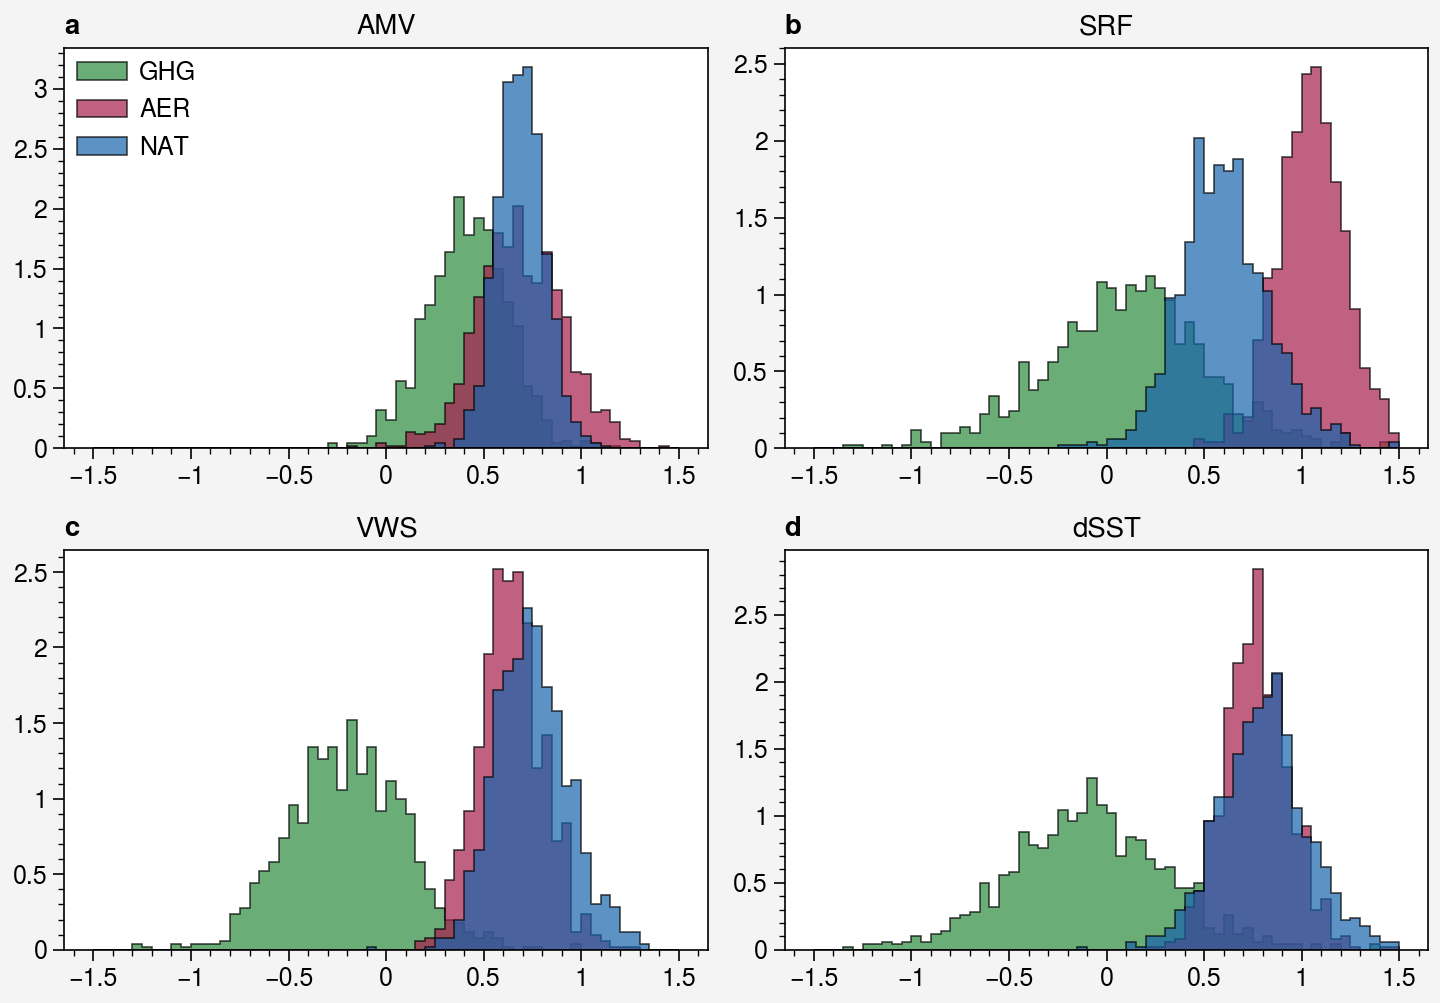

In [27]:
layout = [[1, 2], 
          [3, 4]]
fig, axs = pplt.subplots(layout, sharey=False, sharex=False, 
                          refnum=1, refwidth=1, refheight=2, journal='nat2', )#wratios= [1, 1, 1, 1, 1, 1], hratios=[1, 1],hratios=[1, 1, 1], wratios= [1, 1, 1, 1, 1, 1]

lev = np.arange(-1.5, 1.51, 0.05)
axs[0].hist(ds_role.coe.sel(var='amv', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9', label='GHG')
axs[0].hist(ds_role.coe.sel(var='amv', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9', label='AER')
axs[0].hist(ds_role.coe.sel(var='amv', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9', label='NAT')

axs[1].hist(ds_role.coe.sel(var='spr', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)
axs[1].hist(ds_role.coe.sel(var='spr', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9',)
axs[1].hist(ds_role.coe.sel(var='spr', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9',)

axs[2].hist(ds_role.coe.sel(var='vws', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)
axs[2].hist(ds_role.coe.sel(var='vws', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9',)
axs[2].hist(ds_role.coe.sel(var='vws', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9',)

axs[3].hist(ds_role.coe.sel(var='dsst', forcing='hist_GHG').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)
axs[3].hist(ds_role.coe.sel(var='dsst', forcing='hist_aer').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='pink9',)
axs[3].hist(ds_role.coe.sel(var='dsst', forcing='hist_nat').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='blue9',)


axs[0].legend(ncols=1, frame=False,  loc='ul')
axs.format(abc=True)
axs[0].format(title='AMV')
axs[1].format(title='SRF')
axs[2].format(title='VWS')
axs[3].format(title='dSST')

plt.savefig('1pfigs/r1.dom.ana.reg_coe.pdf')

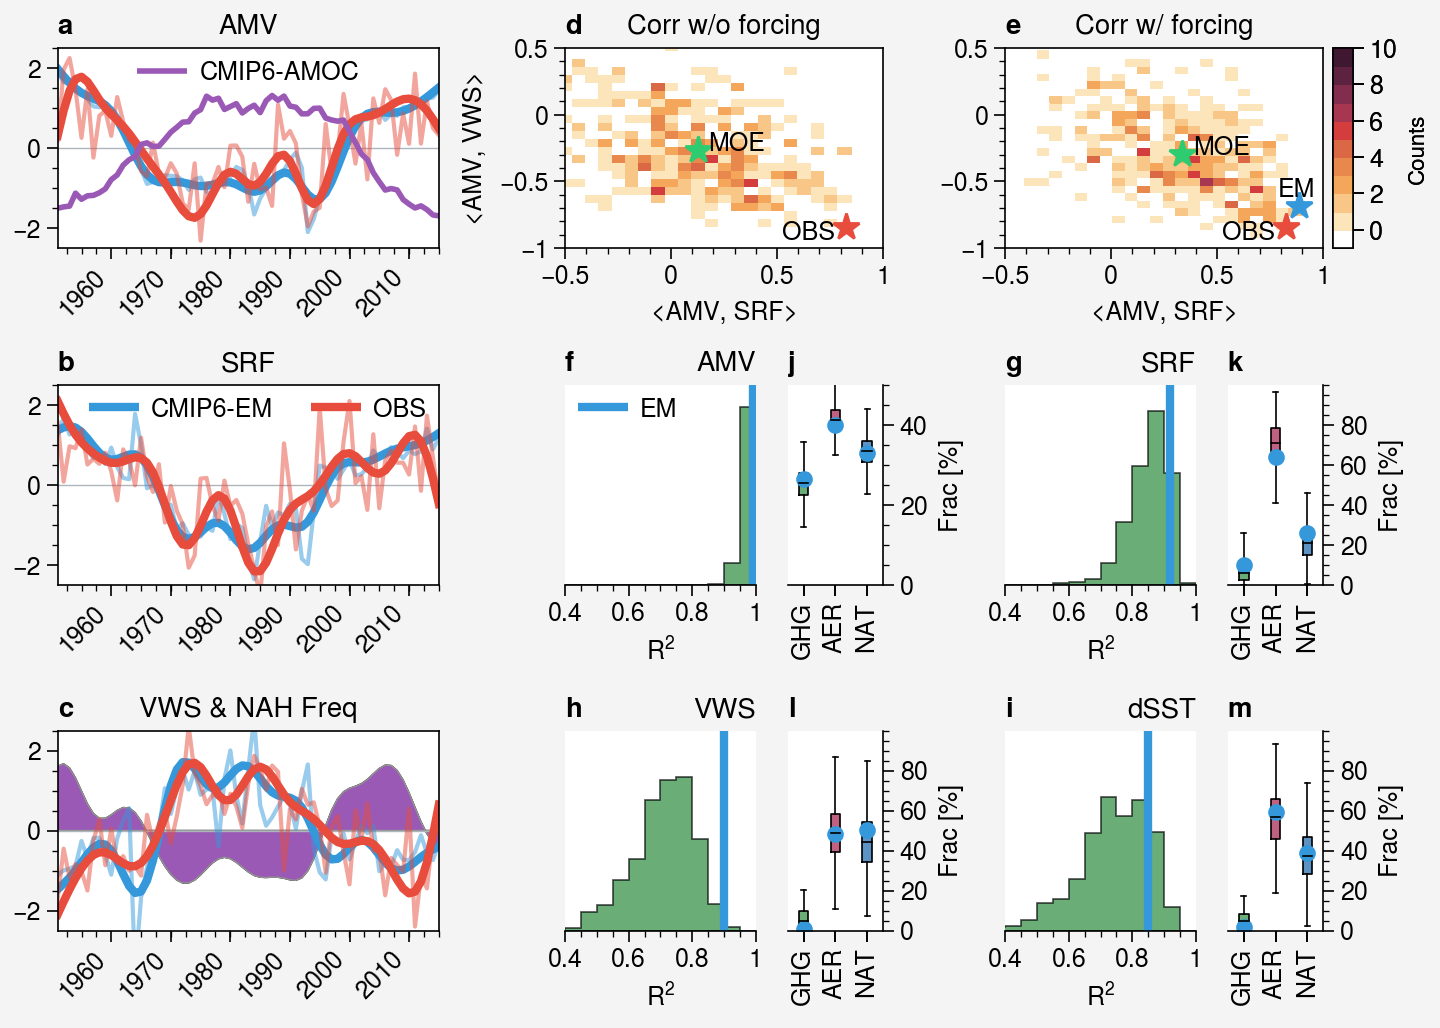

In [28]:
layout = [[1, 1, 2, 2, 3, 3],
          [4, 4, 5, 5, 6, 6],
          [7, 8, 9, 10, 11, 12],
]

layout = [
    [1, 1, 1,1, 4, 4, 4, 5, 5, 5],
    [2, 2, 2,2, 6, 6, 10,  7, 7,11],     
    [3, 3, 3,3, 8, 8, 12,  9, 9,13],      
         ]

fig, axs = pplt.subplots(layout, sharey=False, sharex=False, 
                          refnum=2, refwidth=1, refheight=1, journal='nat2', )#wratios= [1, 1, 1, 1, 1, 1], hratios=[1, 1],hratios=[1, 1, 1], wratios= [1, 1, 1, 1, 1, 1]


dsmld.amv.plot(ax=axs[0], lw=3)


dsml.amv.plot(ax=axs[0], c='C0', alpha=0.5)
obld.amv.plot(ax=axs[0], lw=3)
obl.amv.plot(ax=axs[0], c='C1', alpha=0.5)
amocl.stat.normalize().plot(ax=axs[0], lw=2, label='CMIP6-AMOC', c='C5')
axs[0].hlines(0, dsmld.amv.time.min(), dsmld.amv.time.max(), c='gray5', lw=0.5)


dsmld.spr.plot(ax=axs[1], lw=3, label='CMIP6-EM')
dsml.spr.plot(ax=axs[1], c='C0', alpha=0.5)
detrend_lowpass_filter(obs.spr.dropna('time')).plot(ax=axs[1], lw=3, label='OBS')
obl.spr.plot(ax=axs[1], c='C1', alpha=0.5)
axs[1].hlines(0, dsmld.spr.time.min(), dsmld.spr.time.max(), c='gray5', lw=0.5)

dsmld.vws.plot(ax=axs[2], lw=3)
dsml.vws.plot(ax=axs[2], c='C0', alpha=0.5)
obld.vws.plot(ax=axs[2], lw=3)
obl.vws.plot(ax=axs[2], c='C1', alpha=0.5)
axs[2].hlines(0, dsmld.vws.time.min(), dsmld.vws.time.max(), c='gray5', lw=0.5)


# axs[2].area(hydl, negpos=True, negcolor='#4891bc', poscolor='#e23e28', lw=0.5, edgecolor='gray')
# axs[2].area(hydl, negpos=True, negcolor='lime3', poscolor='orange3', lw=0.5, edgecolor='gray')
axs[2].area(hydl, negpos=True, negcolor='#79AB7C', poscolor='#B46681', lw=0.5, edgecolor='k')
axs[2].area(hydl, negpos=True, negcolor='C5', poscolor='C5', lw=0.5, edgecolor='gray')





lev = np.arange(-1, 10.1, 1)

m = axs[3].pcolor(hhp2[1], hhp2[2], hhp2[0].T, levels = lev, extend='neither')
# fig.colorbar(m, loc='r', width=0.1, ticks=lev[1::2], row=[1,1])
fig.colorbar(m, loc='r', width=0.1, ticks=lev[1::2], row=[1,1], label='Counts', labelsize=8, pad=0.1)
# axs[3].plot(em_amv_spr, em_amv_vws, '*', ms=10, label='EM')
axs[3].plot(obs_corr.amv_spr.mean(), obs_corr.amv_vws.mean(), '*', ms=10, label='OBS', c='C1')
axs[3].plot(corr2.amv_spr.mean(), corr2.amv_vws.mean(), '*', ms=10, c='C4', label='MOE')

axs[3].text(obs_corr.amv_spr.mean()-0.3, obs_corr.amv_vws.mean()-0.1,'OBS')
axs[3].text(corr2.amv_spr.mean()+0.05, corr2.amv_vws.mean(),'MOE')






m = axs[4].pcolor(hhp1[1], hhp1[2], hhp1[0].T, levels = lev, extend='neither')
# axs[3].colorbar(m, loc='r', width=0.1, ticks=lev[::2], label='Counts')
axs[4].plot(em_amv_spr, em_amv_vws, '*', ms=10, label='EM')
axs[4].plot(obs_corr.amv_spr.mean(), obs_corr.amv_vws.mean(), '*', ms=10, label='OBS')
axs[4].plot(corr1.amv_spr.mean(), corr1.amv_vws.mean(), '*', ms=10, c='C4', label='MOE')

axs[4].text(obs_corr.amv_spr.mean()-0.3, obs_corr.amv_vws.mean()-0.1,'OBS')
axs[4].text(em_amv_spr-0.1, em_amv_vws+0.07,'EM')
axs[4].text(corr1.amv_spr.mean()+0.05, corr1.amv_vws.mean(),'MOE')






# lev0 = np.arange(-0.5, 1.01, 0.05)
# lev1 = np.arange(-1, 0.51, 0.05)
# axs[3].hist(c_amv_spr.rename('ensemble'), lev0, filled=True, alpha=0.7,
#             edgecolor='k', density=True, color='indigo9',)

# # axs[3].plot(em_amv_spr, 1, c='C0', label='EM', marker='*', markersize=10)
# axs[3].vlines(em_amv_spr, 2, c='C0', label='EM', lw=3)
# # axs[3].plot(c_amv_spr.mean(), 1, c='indigo9', label='MOE', marker='*', markersize=10)
# axs[3].vlines(c_amv_spr.mean(), 2, c='indigo9', label='MOE', lw=3)
# axs[3].boxh(1, obs_corr.amv_spr.rename(''), fillcolor='C1',
#            mean=True, meancolor='gray8',
#            ec='C1', lw=2, markersize=0)
# axs[4].hist(c_amv_vws.rename('ensemble'), lev1, filled=True, alpha=0.7,
#             edgecolor='k', density=True, color='violet9',)

# # axs[4].plot(em_amv_vws, 1, c='C0', label='CMIP6-EM', marker='*', markersize=10)
# axs[4].vlines(em_amv_vws, 2, c='C0', label='EM', lw=3)
# # axs[4].plot(c_amv_vws.mean(), 1, c='red9', label='MOE', marker='*', markersize=10)
# axs[4].vlines(c_amv_vws.mean(), 2, c='violet9', label='MOE',lw=3)
# axs[4].boxh(1, obs_corr.amv_vws.rename(''), fillcolor='C1',
#            mean=True, meancolor='gray8',
#            ec='C1', lw=2, markersize=0)

axs.format(ylabel='', xlabel='',abc=True, xrotation=0)
# axs[3:5].format(xlim=[-1, 1], xloc='bottom', yloc='none')

# axs[3].legend(ncols=2, frame=False, loc='ul')
# axs[4].legend(ncols=1, frame=False)
axs[0].legend(frame=False, ncols=2)
axs[1].legend(frame=False, ncols=2)

axs[0].format(title='AMV')
axs[1].format(title='SRF')
axs[2].format(title='VWS & NAH Freq')
# axs[3].format(title='<AMV, SPR>')
# axs[4].format(title='<AMV, VWS>')


lev = np.arange(0, 1.1, 0.05)
axs[5].hist(ds_role.r2.sel(var='amv').sum('forcing').rename(''), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)

axs[6].hist(ds_role.r2.sel(var='spr').sum('forcing'), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)

axs[7].hist(ds_role.r2.sel(var='vws').sum('forcing'), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)

axs[8].hist(ds_role.r2.sel(var='dsst').sum('forcing'), lev, filled=True, alpha=0.7,
            edgecolor='k', density=True, color='green9',)

axs[5].vlines(0.99, 0, 20, lw=3, c='C6', label='EM')  # for all forcing 402
axs[6].vlines(0.92, 0, 20, lw=3, c='C6')  # for all forcing 402
axs[7].vlines(0.9, 0, 20, lw=3, c='C6')  # for all forcing 402
axs[8].vlines(0.85, 0, 20, lw=3, c='C6')  # for all forcing 402

axs[5].format(ylim=[0, 20], xlim=[0.4, 1], yloc='none', rtitle='AMV',
              grid='off', xloc='bottom', xticks=[0.4, 0.6, 0.8, 1], xlabel='$R^2$')
axs[6].format(ylim=[0, 8], xlim=[0.4, 1], yloc='none', rtitle='SRF',
              grid='off', xloc='bottom',  xticks=[0.4, 0.6, 0.8, 1], xlabel='$R^2$')
axs[7].format(ylim=[0, 5.5], xlim=[0.4, 1], yloc='none', rtitle='VWS',
              grid='off', xloc='bottom',  xticks=[0.4, 0.6, 0.8, 1], xlabel='$R^2$')
axs[8].format(ylim=[0, 5.5], xlim=[0.4, 1], yloc='none', rtitle='dSST',
              grid='off', xloc='bottom',  xticks=[0.4, 0.6, 0.8, 1], xlabel='$R^2$')

axs[5].legend(frame=False, loc='ul')



percent_amv = ds_role.normRelaImpt.sel(var='amv', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])
percent_vws = ds_role.normRelaImpt.sel(var='vws', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])
percent_spr = ds_role.normRelaImpt.sel(var='spr', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])
percent_dsst = ds_role.normRelaImpt.sel(var='dsst', forcing=['hist_GHG', 'hist_aer', 'hist_nat'])

axs[9].box(percent_amv, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)
axs[10].box(percent_spr, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)
axs[11].box(percent_vws, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)
axs[12].box(percent_dsst, cycle=['green9', 'pink9', 'blue9'], alpha=0.7, markersize=0)

axs[9].plot([0, 1, 2], [26.3, 40, 33], '.', c='C6', ms='10') # all forcing run, 402, 
axs[10].plot([0, 1, 2], [10, 64, 26], '.', c='C6', ms='10') # all forcing run, 402, 
axs[11].plot([0, 1, 2], [1, 48.5, 50.5], '.', c='C6', ms='10') # all forcing run, 402, 
axs[12].plot([0, 1, 2], [1.8, 59.4, 38.8], '.', c='C6', ms='10') # all forcing run, 402, 



axs[9].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]', xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 50])
axs[10].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]',xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 100], yticks=[0, 20, 40, 60, 80])
axs[11].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]',xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 100], yticks=[0, 20, 40, 60, 80])
axs[12].format(xticklabels=['GHG', 'AER', 'NAT'], xlabel='', ylabel='Frac [%]',xrotation=90,
              yloc='right', xloc='bottom', ylim=[0, 100], yticks=[0, 20, 40, 60, 80])


axs.format(abc=True)
axs[0:3].format(xlabel='', ylim=[-2.5, 2.5], xrotation=45)
axs[3:5].format(xlim=[-0.5, 1], ylim=[-1, 0.5], xlabel='<AMV, SRF>')
# axs[3].format()
axs[4].format(title='Corr w/ forcing')
axs[3].format(title='Corr w/o forcing', ylabel='<AMV, VWS>')



plt.savefig('1pfigs/r1.fig.new.2.2.pdf')

# set_position([ll, b + 0.1*h, ww, h*0.8])



In [29]:
corr1.where((corr1.amv_spr > obs_corr.amv_spr.mean()) & (corr1.amv_vws < obs_corr.amv_vws.mean()), drop=True) 


<xarray.Dataset>
Dimensions:  (mb: 1)
Coordinates:
  * mb       (mb) object 'EC-Earth3-AerChem_r1i1p1f1'
Data variables:
    amv_spr  (mb) float64 0.8271
    amv_vws  (mb) float64 -0.8587
Attributes:
    units:        
    Description:  Pearson Correlation Coefficients between amv and spr.

In [30]:
gm = corr1.where((corr1.amv_spr > 0.7) & (corr1.amv_vws < -0.7), drop=True).mb
corr1.where((corr1.amv_spr > 0.7) & (corr1.amv_vws < -0.7), drop=True).to_dataframe()

,amv_spr,amv_vws
mb,,
CanESM5_r24i1p2f1,0.750646,-0.711327
CanESM5_r32i1p2f1,0.744469,-0.731042
EC-Earth3_r13i1p1f1,0.732730,-0.730087
EC-Earth3_r10i1p1f1,0.898530,-0.722115
EC-Earth3_r17i1p1f1,0.774941,-0.757420
EC-Earth3_r19i1p1f1,0.751052,-0.765256
EC-Earth3_r23i1p1f1,0.874320,-0.738881
EC-Earth3-AerChem_r1i1p1f1,0.827064,-0.858701
IPSL-CM6A-LR_r6i1p1f1,0.713634,-0.743888


In [31]:
corr2.sel(mb=gm).to_dataframe()

,amv_spr,amv_vws
mb,,
CanESM5_r24i1p2f1,0.419815,-0.652808
CanESM5_r32i1p2f1,0.372648,-0.652105
EC-Earth3_r13i1p1f1,0.390927,-0.161023
EC-Earth3_r10i1p1f1,0.680160,-0.491402
EC-Earth3_r17i1p1f1,0.463664,-0.143565
EC-Earth3_r19i1p1f1,0.206683,-0.309517
EC-Earth3_r23i1p1f1,0.452036,-0.675365
EC-Earth3-AerChem_r1i1p1f1,0.549470,-0.716858
IPSL-CM6A-LR_r6i1p1f1,0.374213,-0.615223


In [32]:
corr2.where((corr2.amv_spr > 0.7) & (corr2.amv_vws < -0.7), drop=True) 

<xarray.Dataset>
Dimensions:  (mb: 2)
Coordinates:
  * mb       (mb) object 'CNRM-ESM2-1_r2i1p1f2' 'FGOALS-g3_r4i1p1f1'
Data variables:
    amv_spr  (mb) float64 0.7353 0.7438
    amv_vws  (mb) float64 -0.7115 -0.8364
Attributes:
    units:        unitless
    Description:  Pearson Correlation Coefficients between amv and spr.

In [33]:
high_9 = {'TaiESM1',
 'CESM2-FV2',
 'SAM0-UNICON',
 'E3SM-1-0',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CESM2',
 'NorESM2-LM',
 'NorESM2-MM',
 'ACCESS-ESM1-5',
 'ACCESS-CM2',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'CNRM-CM6-1',
 'MIROC6'
 }
low_9 = {
 'GFDL-ESM4',
 'MIROC-ES2L',
 'BCC-CSM2-MR',
 'CNRM-ESM2-1',
 'GFDL-CM4',
 'GISS-E2-1-G',
 'CanESM5',
 'EC-Earth3-Veg',
 'IPSL-CM6A-LR',
 'BCC-ESM1',
 'FGOALS-g3',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'INM-CM4-8',
 'CAMS-CSM1-0'}

hh = []
ll = []
for mbb in corr1.mb:
    md_name = str(mbb.values).split('_')[0]
    if md_name in high_9:
        hh.append(str(mbb.values))
    if md_name in low_9:
        ll.append(str(mbb.values))

In [34]:
dsm_hh = ds.sel(mb=hh).mean('mb')
dsml_hh = dsm_hh.map(detrend2)
dsmld_hh = dsm_hh.map(detrend_lowpass_filter2)

dsm_ll = ds.sel(mb=ll).mean('mb')
dsml_ll = dsm_ll.map(detrend2)
dsmld_ll = dsm_ll.map(detrend_lowpass_filter2)

In [35]:
dsm_hh1 = ds.sel(mb=hh)
dsml_hh1 = dsm_hh1.map(detrend2)
dsmld_hh1 = dsm_hh1.map(detrend_lowpass_filter2)

In [36]:
dsm_ll1 = ds.sel(mb=ll)
dsml_ll1 = dsm_ll1.map(detrend2)
dsmld_ll1 = dsm_ll1.map(detrend_lowpass_filter2)

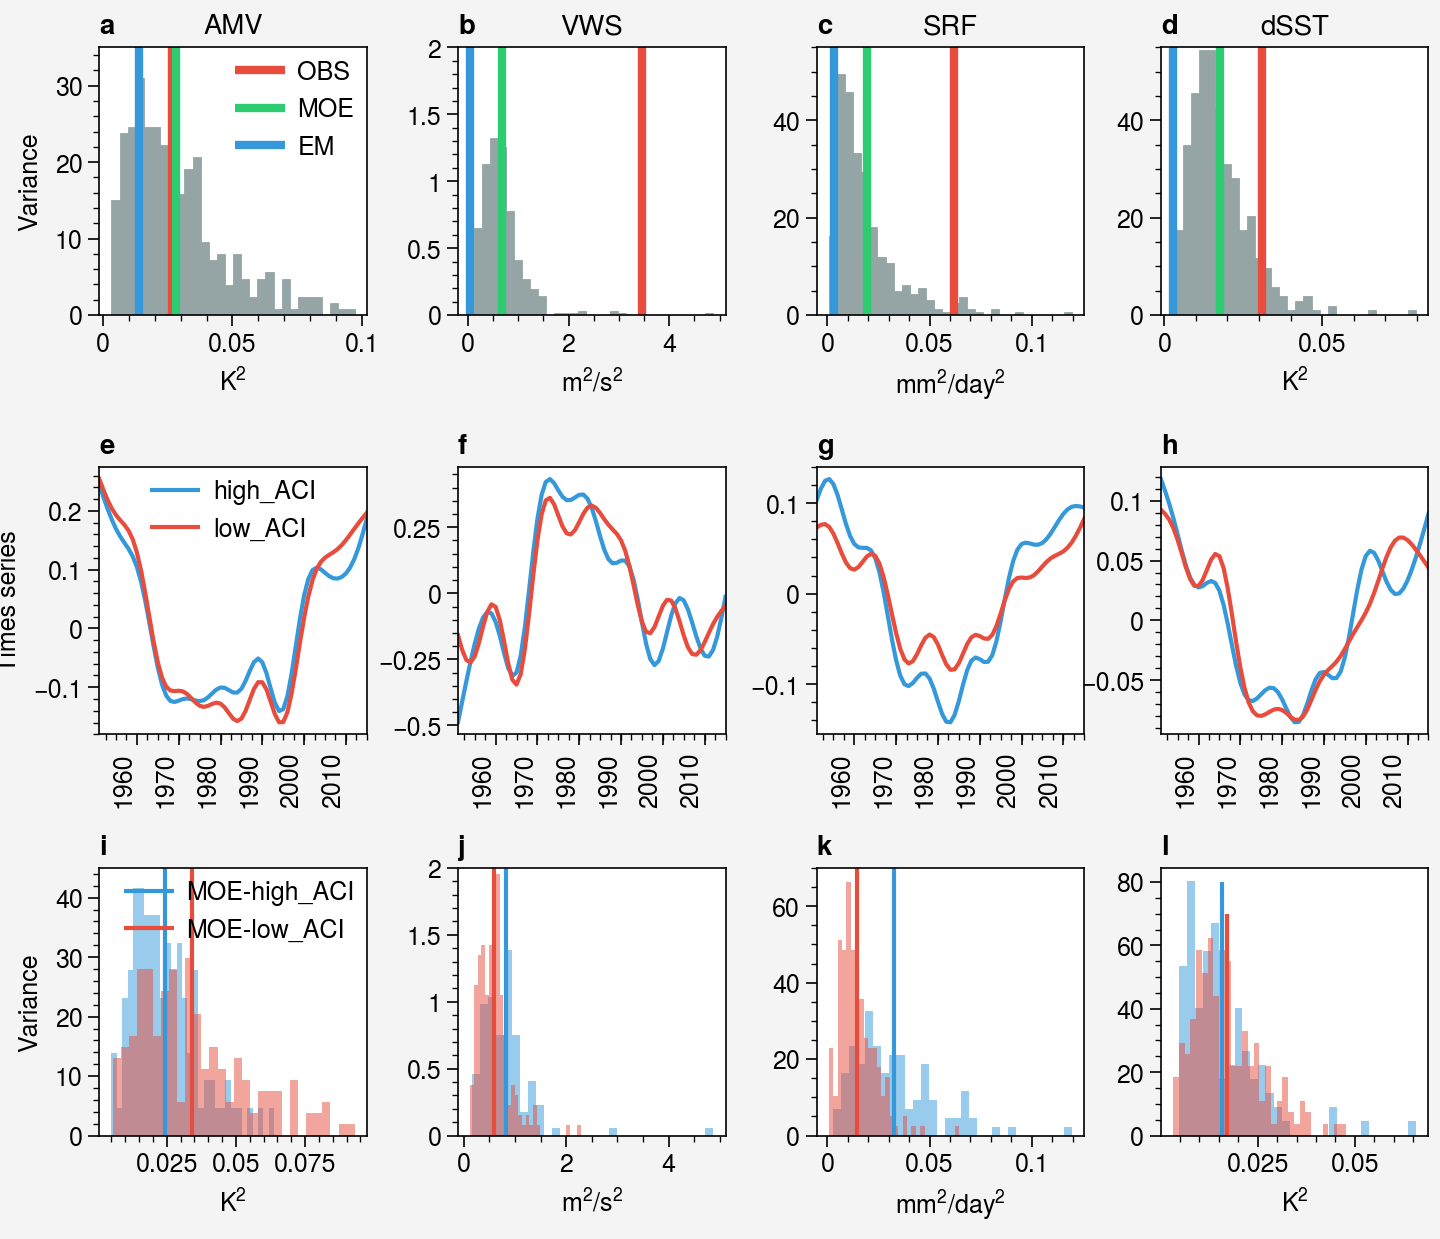

In [37]:

fig, axs = pplt.subplots(nrows=3, ncols=4, sharey=False, sharex=False, journal='nat2')

lv=35
dsldvar.amv.plot.hist(bins=30, ax=axs[0], c='C2', density=True,)
axs[0].vlines(obldvar.amv, lv, c='C1', label='OBS', lw=3)
axs[0].vlines(dsldvar.amv.mean('mb'), lv, c='C4', label='MOE', lw=3)
axs[0].vlines(dsmldvar.amv, lv, c='C0', label='EM', lw=3)


lv=2
dsldvar.vws.plot.hist(bins=30, ax=axs[1], c='C2', density=True)
axs[1].vlines(obldvar.vws, lv, c='C1', label='OBS', lw=3)
axs[1].vlines(dsldvar.vws.mean('mb'), lv, c='C4', label='MOE', lw=3)
axs[1].vlines(dsmldvar.vws, lv, c='C0', label='EM', lw=3)

lv=55
dsldvar.spr.plot.hist(bins=30, ax=axs[2], c='C2', density=True)
axs[2].vlines(obldvar.spr, lv, c='C1', label='OBS', lw=3)
axs[2].vlines(dsldvar.spr.mean('mb'), lv, c='C4', label='MOE', lw=3)
axs[2].vlines(dsmldvar.spr, lv, c='C0', label='EM', lw=3)

lv=55
dsldvar.dsst.plot.hist(bins=30, ax=axs[3], c='C2', density=True)
axs[3].vlines(obldvar.dsst, lv, c='C1', label='OBS', lw=3)
axs[3].vlines(dsldvar.dsst.mean('mb'), lv, c='C4', label='MOE', lw=3)
axs[3].vlines(dsmldvar.dsst, lv, c='C0', label='EM', lw=3)



dsmld_hh.amv.plot(ax=axs[4], label='high_ACI')
dsmld_ll.amv.plot(ax=axs[4], label='low_ACI')

dsmld_hh.vws.plot(ax=axs[5], label='high_ACI')
dsmld_ll.vws.plot(ax=axs[5], label='low_ACI')

dsmld_hh.spr.plot(ax=axs[6], label='high_ACI')
dsmld_ll.spr.plot(ax=axs[6], label='low_ACI')

dsmld_hh.dsst.plot(ax=axs[7], label='high_ACI')
dsmld_ll.dsst.plot(ax=axs[7], label='low_ACI')



dsmld_hh1.amv.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[8])
axs[8].vlines(dsmld_hh1.amv.var('time').mean('mb'), 0, 45, label='MOE-high_ACI', c='C0')
dsmld_ll1.amv.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[8])
axs[8].vlines(dsmld_ll1.amv.var('time').mean('mb'), 0, 45, label='MOE-low_ACI', c='C1')

dsmld_hh1.vws.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[9])
axs[9].vlines(dsmld_hh1.vws.var('time').mean('mb'), 0, 2, label='MOE-high_ACI', c='C0')
dsmld_ll1.vws.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[9])
axs[9].vlines(dsmld_ll1.vws.var('time').mean('mb'), 0, 2, label='MOE-low_ACI', c='C1')

dsmld_hh1.spr.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[10])
axs[10].vlines(dsmld_hh1.spr.var('time').mean('mb'), 0, 70, label='MOE-high_ACI', c='C0')
dsmld_ll1.spr.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[10])
axs[10].vlines(dsmld_ll1.spr.var('time').mean('mb'), 0, 70, label='MOE-low_ACI', c='C1')

dsmld_hh1.dsst.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[11])
axs[11].vlines(dsmld_hh1.dsst.var('time').mean('mb'), 0, 80, label='MOE-high_ACI', c='C0')
dsmld_ll1.dsst.var('time').plot.hist(bins=30, alpha=0.5, density=True, ax=axs[11])
axs[11].vlines(dsmld_ll1.dsst.var('time').mean('mb'), 0, 70, label='MOE-low_ACI', c='C1')

axs.format(ylabel='', xlabel='', abc=True)
axs[0].format(ylabel='Variance', title='AMV', xlabel='$K^2$')
axs[4].format(ylabel='Times series')
axs[8].format(ylabel='Variance')
axs[1].format(title='VWS', xlabel='$m^2/s^2$')
axs[2].format(title='SRF', xlabel='$mm^2/day^2$')
axs[3].format(title='dSST', xlabel='$K^2$')

axs[4].legend(frame=False, ncols=1)
axs[0].legend(frame=False, ncols=1)
axs[8].legend(frame=False, ncols=1)

axs[8].format(xlabel='$K^2$')
axs[9].format(xlabel='$m^2/s^2$')
axs[10].format(xlabel='$mm^2/day^2$')
axs[11].format(xlabel='$K^2$')

# plt.savefig('1pfigs/r1.extended.fig.x.pdf')


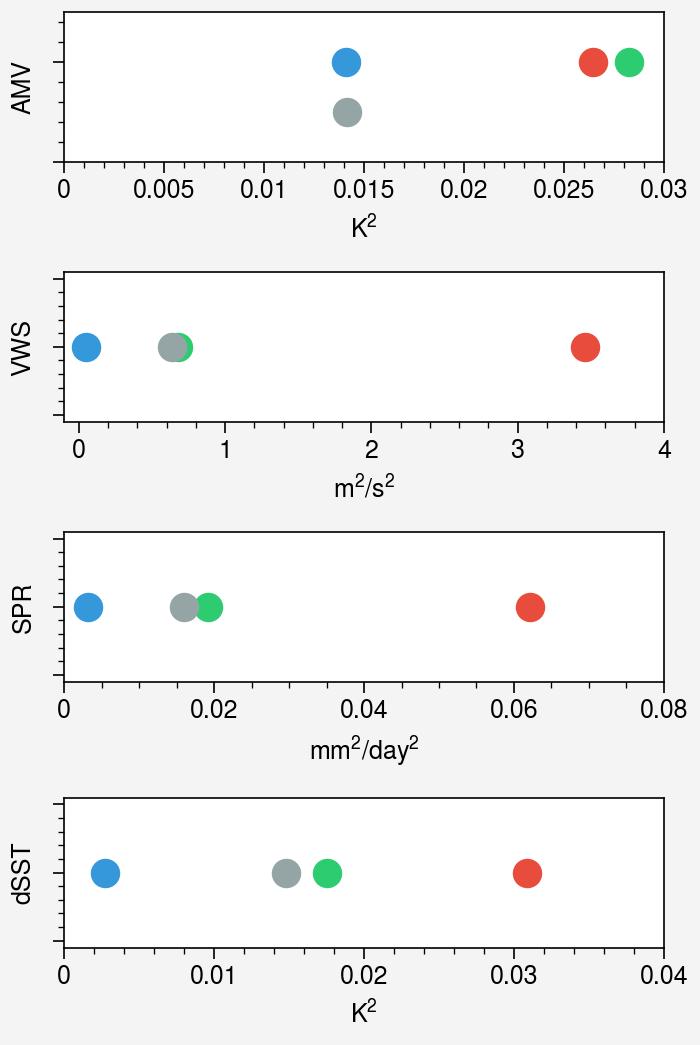

In [38]:
fig, axs = pplt.subplots(nrows=4, ncols=1, sharey=False, sharex=False,
                         refwidth=2, refaspect=4, journal='nat1')

lv=35
axs[0].scatter(obldvar.amv, 1, c='C1', label='OBS', markersize=100)
axs[0].scatter(dsldvar.amv.mean('mb'), 1, c='C4', label='MOE', markersize=100)
axs[0].scatter(dsmldvar.amv, 1, c='C0', label='EM', markersize=100)
axs[0].scatter(dsldvar.amv.mean('mb') - dsmldvar.amv, 0.5, c='C2', label='IV', markersize=100)

axs[1].scatter(obldvar.vws, 1, c='C1', label='OBS', markersize=100)
axs[1].scatter(dsldvar.vws.mean('mb'), 1, c='C4', label='MOE', markersize=100)
axs[1].scatter(dsmldvar.vws, 1, c='C0', label='EM', markersize=100)
axs[1].scatter(dsldvar.vws.mean('mb') - dsmldvar.vws, 1, c='C2', label='IV', markersize=100)

axs[2].scatter(obldvar.spr, 1, c='C1', label='OBS', markersize=100)
axs[2].scatter(dsldvar.spr.mean('mb'), 1, c='C4', label='MOE', markersize=100)
axs[2].scatter(dsmldvar.spr, 1, c='C0', label='EM', markersize=100)
axs[2].scatter(dsldvar.spr.mean('mb') - dsmldvar.spr, 1, c='C2', label='IV', markersize=100)

axs[3].scatter(obldvar.dsst, 1, c='C1', label='OBS', markersize=100)
axs[3].scatter(dsldvar.dsst.mean('mb'), 1, c='C4', label='MOE', markersize=100)
axs[3].scatter(dsmldvar.dsst, 1, c='C0', label='EM', markersize=100)
axs[3].scatter(dsldvar.dsst.mean('mb') - dsmldvar.dsst, 1, c='C2', label='IV', markersize=100)

axs[0].format(xlim=[0, 0.03], xlabel='$K^2$', yticklabels=[], ylabel='AMV', ylim=[0, 1.5])
axs[1].format(xlim=[-0.1, 4], xlabel='$m^2/s^2$', yticklabels=[], ylabel='VWS')
axs[2].format(xlim=[0, 0.08], xlabel='$mm^2/day^2$', yticklabels=[], ylabel='SPR')
axs[3].format(xlim=[0, 0.04], xlabel='$K^2$', yticklabels=[], ylabel='dSST')
plt.savefig('1pfigs/variance.amv.vws.spr.dsst.pdf')
# axs[2].scatter(dsmldvar.amv, lv, c='C0', label='EM', lw=3)

In [39]:
dsmld_hh.amv.var('time')
# dsmld_ll.amv.var('time')

<xarray.DataArray 'amv' ()>
array(0.01357163)

In [40]:
dsmld_hh.var('time')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 0.01357
    vws      float64 0.05968
    spr      float64 0.007064
    dsst     float64 0.003129

In [41]:
dsmld_ll.var('time')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 0.01863
    vws      float64 0.04499
    spr      float64 0.00264
    dsst     float64 0.00328

In [42]:
dsmld_hh1.var('time').mean('mb')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 0.02432
    vws      float64 0.8155
    spr      float64 0.03242
    dsst     float64 0.01588

In [43]:
dsmld_ll1.var('time').mean('mb')

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 0.03398
    vws      float64 0.5918
    spr      float64 0.01463
    dsst     float64 0.01709

In [53]:
iv_hh = dsmld_hh1.var('time').mean('mb') - dsmld_hh.var('time')
iv_ll = dsmld_ll1.var('time').mean('mb') - dsmld_ll.var('time')
iv_all = dsldvar.mean('mb') - dsmldvar

In [45]:
r_hh = dsmld_hh.var('time') / iv_hh
r_hh

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 1.263
    vws      float64 0.07897
    spr      float64 0.2786
    dsst     float64 0.2454

In [46]:
r_ll = dsmld_ll.var('time') / iv_ll
r_ll

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 1.214
    vws      float64 0.08228
    spr      float64 0.2201
    dsst     float64 0.2374

In [58]:
r_all = dsmldvar / iv_all
r_all

<xarray.Dataset>
Dimensions:  ()
Data variables:
    amv      float64 0.9959
    vws      float64 0.07244
    spr      float64 0.1965
    dsst     float64 0.1862

In [59]:
moe = xr.concat([dsldvar.mean('mb').assign_coords(ACI='all'),
                    dsmld_hh1.var('time').mean('mb').assign_coords(ACI='high'),
                    dsmld_ll1.var('time').mean('mb').assign_coords(ACI='low'),
                    
                ], dim='ACI')

iv = xr.concat([iv_all.assign_coords(ACI='all'),
                iv_hh.assign_coords(ACI='high'),
               iv_ll.assign_coords(ACI='low'),
               ], dim='ACI')

em = xr.concat([dsmldvar.assign_coords(ACI='all'),
                dsmld_hh.var('time').assign_coords(ACI='high'),
               dsmld_ll.var('time').assign_coords(ACI='low'),
               ], dim='ACI')

stn = xr.concat([r_all.assign_coords(ACI='all'),
                r_hh.assign_coords(ACI='high'),
                 r_ll.assign_coords(ACI='low'),
                ], dim='ACI')

In [60]:
moe.to_dataframe().round(4)

,amv,vws,spr,dsst
ACI,,,,
all,0.0283,0.6794,0.0192,0.0175
high,0.0243,0.8155,0.0324,0.0159
low,0.0340,0.5918,0.0146,0.0171


In [61]:
iv.to_dataframe().round(4)

,amv,vws,spr,dsst
ACI,,,,
all,0.0142,0.6335,0.0160,0.0148
high,0.0107,0.7558,0.0254,0.0128
low,0.0153,0.5468,0.0120,0.0138


In [62]:
em.to_dataframe().round(4)

,amv,vws,spr,dsst
ACI,,,,
all,0.0141,0.0459,0.0031,0.0027
high,0.0136,0.0597,0.0071,0.0031
low,0.0186,0.0450,0.0026,0.0033


In [63]:
stn.to_dataframe().round(4)

,amv,vws,spr,dsst
ACI,,,,
all,0.9959,0.0724,0.1965,0.1862
high,1.2626,0.0790,0.2786,0.2454
low,1.2143,0.0823,0.2201,0.2374


In [64]:
moe = moe.to_dataframe()
moe['metric'] = 'MOE'

iv = iv.to_dataframe()
iv['metric'] = 'IV'

em = em.to_dataframe()
em['metric'] = 'EM'

stn = stn.to_dataframe()
stn['metric'] = 'S/N ratio'


In [65]:
out = pd.concat([moe, iv, em, stn], axis=0)
out = out.reset_index()
out = out.set_index(['metric', 'ACI'])
out

amv       vws       spr      dsst
metric    ACI                                         
MOE       all   0.028275  0.679364  0.019171  0.017513
          high  0.024320  0.815457  0.032421  0.015883
          low   0.033981  0.591803  0.014633  0.017094
IV        all   0.014167  0.633473  0.016022  0.014764
          high  0.010749  0.755776  0.025358  0.012754
          low   0.015346  0.546810  0.011993  0.013815
EM        all   0.014108  0.045891  0.003149  0.002748
          high  0.013572  0.059681  0.007064  0.003129
          low   0.018635  0.044993  0.002640  0.003280
S/N ratio all   0.995866  0.072443  0.196530  0.186155
          high  1.262636  0.078966  0.278569  0.245360
          low   1.214274  0.082282  0.220122  0.237408

In [66]:
out.round(4).to_csv('1pfigs/extended.fig.table.9.csv')